<a href="https://colab.research.google.com/github/Undreak/MML_Nombres_Premiers/blob/master/Nombres_Premiers.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Notebook Nombres Premiers

## Importations néscessaires

In [1]:
%tensorflow_version 1.x
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
%matplotlib inline

TensorFlow 1.x selected.


## Données

In [2]:
#@title Télécharger les données

#@markdown Ceci va télécharger l'archive depuis Github et la décompresser dans le dossier `data`

import sys
import os
import tarfile
from urllib.request import urlretrieve

URL = "https://github.com/Undreak/MML_Nombres_Premiers/raw/master/primes.tar.gz"
FILE = "primes.tar.gz"

def download_data(output_dir):

  if not os.path.exists(output_dir):
    print(f"Creating directory {output_dir}")
    os.mkdir(output_dir)

  output_file = os.path.join(output_dir, FILE)
  if os.path.exists(output_file):
    print(f"{FILE} already downloaded.")

  print(f"Downloading from {URL}...")
  urlretrieve(URL, output_file)
  print(f"==> File saved as {output_file}")

  if FILE.endswith("tar.gz"):
    print("Extracting tarball...")
    with tarfile.open(output_file, "r:gz") as f:
      f.extractall(output_dir)
    print("Done.")

download_data("data")

Creating directory data
==> File saved as data/primes.tar.gz
Extracting tarball...
Done.


### Charger les données

In [3]:
data = np.loadtxt('data/primes.csv', skiprows=1, delimiter=',').astype(int)

On prépare les données pour l'entrainnement et le test.

In [4]:
N = 10000

X_train = np.arange(2,N+2)
Y_train = np.isin(X_train, data[:N+2,1])*1

X_test = np.arange(N+3, 2*N+3)
Y_test = np.isin(X_test, data[N+3:2*N+3,1])*1

## Modèle

On construit un réseau de neurones convolutif

In [65]:
f_activation = 'relu'
l_activation = 'sigmoid'
dropout_rate = 0.05
model = tf.keras.Sequential([
  tf.keras.layers.Dense(8, activation=f_activation, input_dim=1),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(16, activation=f_activation),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(16, activation=f_activation),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(32, activation=f_activation),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(64, activation=f_activation),
  tf.keras.layers.Dropout(dropout_rate),
  tf.keras.layers.Dense(1, activation=l_activation)
])

model.compile(optimizer='Adam', loss='binary_crossentropy')
model.summary()

Model: "sequential_14"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_86 (Dense)             (None, 8)                 16        
_________________________________________________________________
dropout_71 (Dropout)         (None, 8)                 0         
_________________________________________________________________
dense_87 (Dense)             (None, 16)                144       
_________________________________________________________________
dropout_72 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_88 (Dense)             (None, 16)                272       
_________________________________________________________________
dropout_73 (Dropout)         (None, 16)                0         
_________________________________________________________________
dense_89 (Dense)             (None, 32)              

In [66]:
history = model.fit(X_train, Y_train,
  batch_size=32,
  epochs=15,
  validation_split=0.3,
  verbose=0)

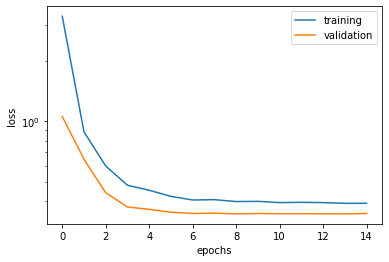

In [67]:
plt.figure()                    
plt.plot(history.history['loss'], label='training')
plt.plot(history.history['val_loss'], label='validation')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.yscale('log')
plt.legend()
plt.show()

In [68]:
ev = model.evaluate(X_test, Y_test)
print(ev)

10000/10000 [==============================] - 0s 29us/sample - loss: 0.1089
0.108921429169178
